# Finance notebooks #
## Some basics: Portfolio finance ##

Let's make some portfolio math, as usual with **python** (https://www.python.org/) and **pandas** (http://pandas.pydata.org/). 

In [1]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np

# Defines the chart color scheme using Tableu's Tableau10 
plt.style.use('https://gist.githubusercontent.com/mbonix/8478091db6a2e6836341c2bb3f55b9fc/raw/7155235ed03e235c38b66c160d402192ad4d94d9/tableau10.mplstyle')

%matplotlib inline

We are going to download some prices, just as an example. We'll work on **Apple** (AAPL), **Alphabet** (former Google, GOOGL), **Microsoft** (MSFT), **McDonald's** (MCD), **Coca-Cola** (KO) over a ten-year period.

In [2]:
# List of stocks tickers
STOCKS = ['NASDAQ:AAPL', 'NASDAQ:GOOGL', 'NASDAQ:MSFT', 'NYSE:MCD', 'NYSE:KO']

# Analysis period
START = '12-30-2006'
END = '12-31-2016'

data = web.DataReader(STOCKS, 'google', pd.to_datetime(START), pd.to_datetime(END))

# Only Close prices are relevant for analysis
prices = data.loc['Close', :, :]
prices.tail(10)

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Date,,,,,
2016-12-16,115.97,809.84,62.30,41.74,123.24
2016-12-19,116.64,812.50,63.62,41.67,122.99
2016-12-20,116.95,815.20,63.54,41.66,123.33
2016-12-21,117.06,812.20,63.54,41.57,123.18
2016-12-22,116.29,809.68,63.55,41.55,123.72
2016-12-23,116.52,807.80,63.24,41.60,123.14
2016-12-27,117.26,809.93,63.28,41.61,123.07
2016-12-28,116.76,804.57,62.99,41.39,122.68
2016-12-29,116.73,802.88,62.90,41.60,122.79


Now, let's calculate an **annualized return** for each of the stocks over the entire period.

In [3]:
compound_returns = (1 + (prices.iloc[-1, :]).to_frame().T / (prices.iloc[0, :])) ** 0.1 - 1
compound_returns.index = ['Compound Annual Return']
compound_returns

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Compound Annual Return,0.267186,0.159332,0.119102,0.104706,0.142054


Then we could compute an **annual volatility** over the period, daily sampled.

In [4]:
annual_volatility = prices.fillna(method='pad').pct_change().std().apply(lambda x: x * 260 ** 0.5).to_frame().T
annual_volatility.index = ['Annual Volatility']
annual_volatility

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Annual Volatility,0.33434,0.303486,0.288101,0.191743,0.194047


Let's join these stats into a single dataframe.

In [5]:
stock_moments = pd.concat((compound_returns, annual_volatility))
stock_moments

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Compound Annual Return,0.267186,0.159332,0.119102,0.104706,0.142054
Annual Volatility,0.334340,0.303486,0.288101,0.191743,0.194047


And let's make a chart, plotting volatities on X-axis and returns on Y-axis.

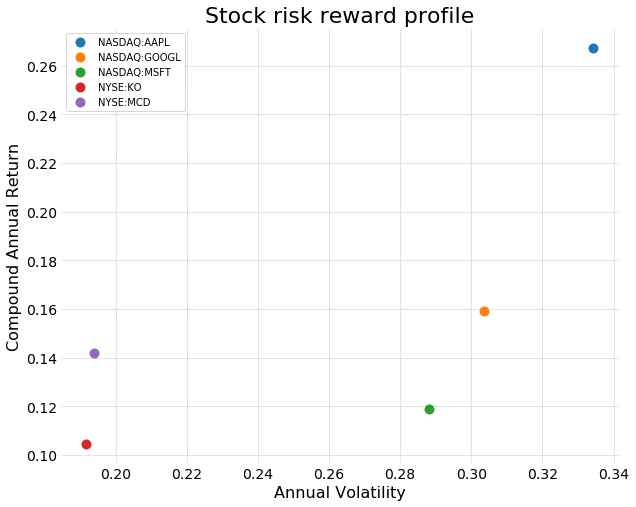

In [6]:
f = plt.figure(figsize=(10, 8));
ax = f.add_subplot(111);
for n in range(len(stock_moments.columns)):
    ax.plot(stock_moments.loc['Annual Volatility', stock_moments.columns[n]], stock_moments.loc['Compound Annual Return', stock_moments.columns[n]], ls='', marker='o', label=stock_moments.columns[n]);
ax.legend(loc='best');
ax.set_xlabel(stock_moments.index[1]);
ax.set_ylabel(stock_moments.index[0]);
ax.set_title('Stock risk reward profile');

A few considerations: **Apple** (AAPL) has delivered a superb return over the period, but at the cost of the highest volatility (risk), while the *old-economy* stocks (**Coca-Cola**: KO e **McDonald's**: MCD) have been characterized by a lower risk and a lower return.

Now, let's calculate the risk-reward profile of a **equally-weighted portfolio** composed by these five stocks. First of all, the return of the portfolio, which is the average of the stock returns, equally-weighted.

In [7]:
WEIGHTS = [0.2, 0.2, 0.2, 0.2, 0.2]
port_moments = pd.DataFrame(index=stock_moments.index, columns=['Equally-weighted Portfolio'])
port_moments.loc['Compound Annual Return', 'Equally-weighted Portfolio'] = (stock_moments.loc['Compound Annual Return', :] * WEIGHTS).sum()
port_moments

,Equally-weighted Portfolio
Compound Annual Return,0.158476
Annual Volatility,NaN


In order to calculate volatility, we need a **covariance matrix**. Luckily enough, Pandas has a function to do exactly that!

In [8]:
cov_mat = prices.fillna(method='pad').pct_change().cov().apply(lambda x: x * 260)
cov_mat

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
NASDAQ:AAPL,0.111783,0.054017,0.044741,0.021701,0.024063
NASDAQ:GOOGL,0.054017,0.092104,0.046194,0.022491,0.024703
NASDAQ:MSFT,0.044741,0.046194,0.083002,0.026737,0.026076
NYSE:KO,0.021701,0.022491,0.026737,0.036766,0.018623
NYSE:MCD,0.024063,0.024703,0.026076,0.018623,0.037654


Let's check that the roots of the diagonal of the matrix are the (annualized) standard deviations of the stocks.

In [9]:
pd.DataFrame(data=[cov_mat.iloc[n, n] ** 0.5 for n in range(len(cov_mat.columns))], index=cov_mat.columns, columns=['Annual Volatility']).T

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Annual Volatility,0.33434,0.303486,0.288101,0.191743,0.194047


The volatility of the portfolio is easily computed.

In [10]:
port_moments.loc['Annual Volatility', 'Equally-weighted Portfolio'] = np.array(WEIGHTS).dot(cov_mat.values).dot(np.array(WEIGHTS).T) ** 0.5
port_moments

,Equally-weighted Portfolio
Compound Annual Return,0.158476
Annual Volatility,0.19799


So, we can plot the risk-reward profile of the **portfolio** on the previous chart.

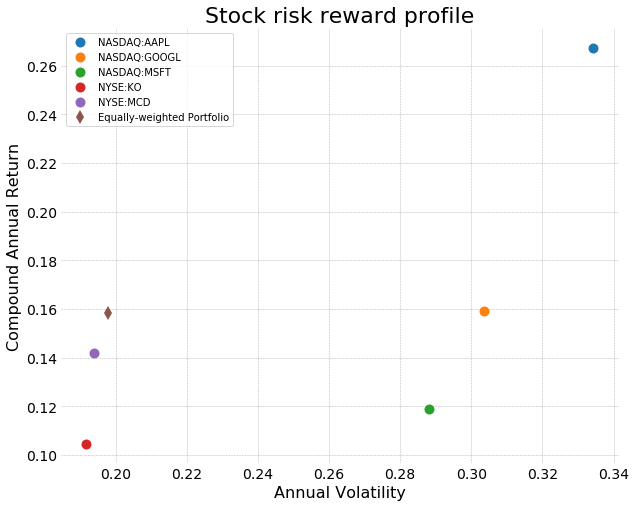

In [11]:
f = plt.figure(figsize=(10, 8));
ax = f.add_subplot(111);
for n in range(len(stock_moments.columns)):
    ax.plot(stock_moments.loc['Annual Volatility', stock_moments.columns[n]], stock_moments.loc['Compound Annual Return', stock_moments.columns[n]], ls='', marker='o', label=stock_moments.columns[n]);
ax.plot(port_moments.loc['Annual Volatility','Equally-weighted Portfolio'], port_moments.loc['Compound Annual Return', 'Equally-weighted Portfolio'], ls='', marker='d', label='Equally-weighted Portfolio');
ax.legend(loc='best');
ax.set_xlabel(stock_moments.index[1]);
ax.set_ylabel(stock_moments.index[0]);
ax.set_title('Stock risk reward profile');

We can notice that the portfolio risk profile is similar to *old economy* stocks, but the historical return benefits from the higher returns of *tech stocks*. **Diversification** at work!

Now, let's build some **random portfolios** and calculate their risk-reward profile. First of all, the weights matrix.

In [77]:
wgts = pd.DataFrame(np.array(np.random.uniform(0, 1, (5000, 5))), columns=prices.columns)
w = wgts.apply(lambda x: x / wgts.sum(axis=1))
w

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
0,0.270845,0.269795,0.033014,0.269393,0.156953
1,0.111105,0.125138,0.076527,0.334278,0.352952
2,0.221398,0.291408,0.212823,0.199991,0.074381
3,0.344858,0.134316,0.305975,0.187393,0.027459
4,0.357855,0.089550,0.050103,0.206363,0.296129
5,0.118283,0.202157,0.165559,0.332108,0.181892
6,0.133565,0.382373,0.025669,0.132206,0.326186
7,0.320789,0.293403,0.045960,0.106839,0.233009
8,0.092553,0.166488,0.251615,0.214966,0.274378
9,0.289671,0.194250,0.244769,0.093943,0.177367


Let's compute **first two moments** of the simulated portfolios.

In [78]:
sim_ports = pd.DataFrame(index=w.index, columns=port_moments.index)
sim_ports.loc[:, 'Compound Annual Return'] = (stock_moments.loc['Compound Annual Return', :] * w).sum(axis=1)
sim_ports.loc[:, 'Annual Volatility'] = np.diag(w.values.dot(cov_mat.values).dot(w.values.T)) ** 0.5
sim_ports

,Compound Annual Return,Annual Volatility
0,0.169788,0.202491
1,0.143878,0.173173
2,0.162439,0.213816
3,0.173506,0.224855
4,0.179523,0.199148
5,0.144145,0.186198
6,0.159847,0.201044
7,0.182219,0.215465
8,0.142708,0.188574
9,0.172531,0.215509


And let's plot those fancy random portfolios on the **risk-reward chart**.

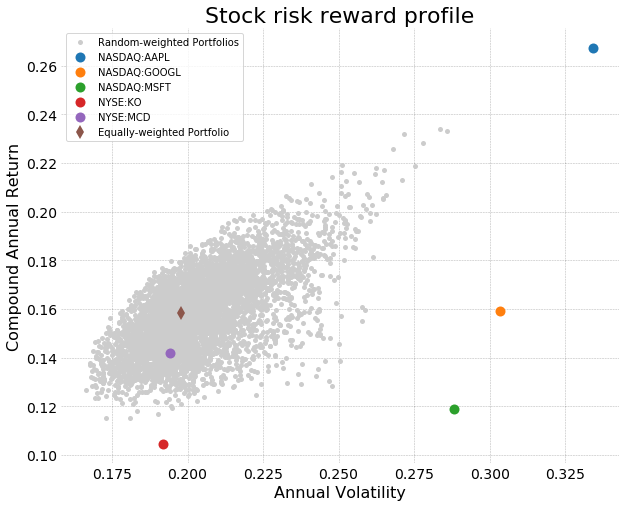

In [79]:
f = plt.figure(figsize=(10, 8));
ax = f.add_subplot(111);
ax.plot(sim_ports.loc[0, 'Annual Volatility'], sim_ports.loc[0, 'Compound Annual Return'], ls='', marker='.', color='#cccccc', label='Random-weighted Portfolios');
for m in range(len(sim_ports.index)):
    ax.plot(sim_ports.loc[m, 'Annual Volatility'], sim_ports.loc[m, 'Compound Annual Return'], ls='', marker='.', color='#cccccc');
for n in range(len(stock_moments.columns)):
    ax.plot(stock_moments.loc['Annual Volatility', stock_moments.columns[n]], stock_moments.loc['Compound Annual Return', stock_moments.columns[n]], ls='', marker='o', label=stock_moments.columns[n]);
ax.plot(port_moments.loc['Annual Volatility','Equally-weighted Portfolio'], port_moments.loc['Compound Annual Return', 'Equally-weighted Portfolio'], ls='', marker='d', label='Equally-weighted Portfolio');
ax.legend(loc='best');
ax.set_xlabel(stock_moments.index[1]);
ax.set_ylabel(stock_moments.index[0]);
ax.set_title('Stock risk reward profile');

We can see that some of the random-weighted portfolios have a better risk-reward profile than the equally-weighted portfolio one and also than each of the stocks profile. So, there is plenty of space for **portfolio optimization**, but... this is another topic.